In [11]:
import os

from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, col, when, sum, row_number, mean

from pyspark.sql.window import Window

import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter 환경에서 대화형 그래프 활성화
# ipympl version : 0.9.3
%matplotlib widget

# Scipy를 사용한 피어슨 상관계수와 p-value
# statistic: 피어슨 상관계수(상관관계의 강도와 방향을 나타냄)
# p-value가 0.05 미만이면 통계적으로 유의미하다고 함
# p-value는 낮을 수록 의미 있음
# scipy version 1.10.1
from scipy.stats import pearsonr


In [12]:
ss = SparkSession.builder\
                .appName('YellowTaxi')\
                .config('spark.executor.memory', '5g')\
                .config('spark.driver.memory', '5g')\
                .getOrCreate()

ss

In [13]:
trip_files = 'trips/*.csv'
zone_file = 'trips/code/lookup.csv'
directory = os.path.join(os.getcwd(), 'data')

In [14]:
df = ss.read.csv(f'file:///{directory}/{trip_files}', inferSchema=True, header = True)
df_zone = ss.read.csv(f'file:///{directory}/{zone_file}', inferSchema=True, header = True)
df, df_zone

(DataFrame[VendorID: int, tpep_pickup_datetime: string, tpep_dropoff_datetime: string, passenger_count: int, trip_distance: double, RatecodeID: int, store_and_fwd_flag: string, PULocationID: int, DOLocationID: int, payment_type: int, fare_amount: double, extra: double, mta_tax: double, tip_amount: double, tolls_amount: double, improvement_surcharge: double, total_amount: double, congestion_surcharge: double],
 DataFrame[LocationID: int, Borough: string, Zone: string, service_zone: string])

In [3]:
### 로컬에서 하기 위해 임시방편으로 하드 코딩
tmp_df1 = ss.read.csv('data/trips/yellow_tripdata_2021-01.csv'
                , inferSchema = True
                , header = True)
tmp_df2 = ss.read.csv('data/trips/yellow_tripdata_2021-02.csv'
                , inferSchema = True
                , header = True)
tmp_df3 = ss.read.csv('data/trips/yellow_tripdata_2021-03.csv'
                , inferSchema = True
                , header = True)

tmp_df4 = ss.read.csv('data/trips/yellow_tripdata_2021-04.csv'
                , inferSchema = True
                , header = True)

tmp_df5 = ss.read.csv('data/trips/yellow_tripdata_2021-05.csv'
                , inferSchema = True
                , header = True)

tmp_df6 = ss.read.csv('data/trips/yellow_tripdata_2021-06.csv'
                , inferSchema = True
                , header = True)

tmp_df7 = ss.read.csv('data/trips/yellow_tripdata_2021-07.csv'
                , inferSchema = True
                , header = True)

df = tmp_df1\
    .union(tmp_df2)\
    .union(tmp_df3)\
    .union(tmp_df4)\
    .union(tmp_df5)\
    .union(tmp_df6)\
    .union(tmp_df7)\

df_zone = ss.read.csv('data/code/lookup.csv'
                , inferSchema = True
                , header = True)


In [4]:
df.show(1)
df.printSchema()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|       1| 2021-01-01 00:30:10|  2021-01-01 00:36:12|              1|          2.1|         1|                 N|         142|          43|           2|        8.0|  3.0|    0.5|       0.0|         0.0|                  0.3

In [16]:
df.count()

15000700

## 0. 방향
1. 쿼리 작성
2. 데이터 프레임으로 구현
3. 데이터 및 컬럼 설명
    - https://www.kaggle.com/datasets/elemento/nyc-yellow-taxi-trip-data


## 1. 전처리

### 1-1. 임시 테이블 만들기

In [15]:
df.createOrReplaceTempView('table1')
df_zone.createOrReplaceTempView('table2')

### 1-2. 음수는 뭐지

In [5]:
ss.sql('''
    SELECT
        payment_type
        , min(tip_amount)
        , max(tip_amount)
        , min(total_amount)
        , max(total_amount)
    FROM table1 as A
    where tip_amount < 0
        or total_amount < 0

    GROUP BY payment_type
    
''').show()

+------------+---------------+---------------+-----------------+-----------------+
|payment_type|min(tip_amount)|max(tip_amount)|min(total_amount)|max(total_amount)|
+------------+---------------+---------------+-----------------+-----------------+
|        null|          -6.33|          15.13|           -95.88|            50.02|
|           1|         -83.95|            0.0|          -133.35|             -3.3|
|           3|         -111.1|          32.06|           -647.8|            -0.31|
|           4|        -333.32|          40.06|          -554.05|             -0.3|
|           2|            0.0|          31.26|           -634.8|            -0.35|
+------------+---------------+---------------+-----------------+-----------------+



### 1-3 결측치 처리

In [6]:
# trip main csv
df.select(
    [
        sum(
            when(
                col(c).isNull() | isnan(c),1)\
        .otherwise(0)
            )\
        .alias(c) for c in df.columns
        
    ]    
).show(truncate = False)

# look up csv
df_zone.select(
    [
        sum(
            when(
                col(c).isNull() | isnan(c),1)\
        .otherwise(0)
            )\
        .alias(c) for c in df_zone.columns
        
    ]    
).show(truncate = False)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|834028  |0                   |0                    |834028         |0            |834028    |834028            |0           |0           |834028      |0          |0    |0      |0         |0           |0                    

In [8]:
df.select('VendorID')\
    .where('VendorID IS NULL')\
    .show(10)

df.select('passenger_count')\
    .where('passenger_count IS NULL')\
    .show(10)

df.select('RatecodeID')\
    .where('RatecodeID IS NULL')\
    .show(10)

df.select('store_and_fwd_flag')\
    .where('store_and_fwd_flag IS NULL')\
    .show(10)

df.select('payment_type')\
    .where('payment_type IS NULL')\
    .show(10)

df.select('improvement_surcharge')\
    .where('improvement_surcharge IS NULL')\
    .show(10)

+--------+
|VendorID|
+--------+
|    null|
|    null|
|    null|
|    null|
|    null|
|    null|
|    null|
|    null|
|    null|
|    null|
+--------+
only showing top 10 rows

+---------------+
|passenger_count|
+---------------+
|           null|
|           null|
|           null|
|           null|
|           null|
|           null|
|           null|
|           null|
|           null|
|           null|
+---------------+
only showing top 10 rows

+----------+
|RatecodeID|
+----------+
|      null|
|      null|
|      null|
|      null|
|      null|
|      null|
|      null|
|      null|
|      null|
|      null|
+----------+
only showing top 10 rows

+------------------+
|store_and_fwd_flag|
+------------------+
|              null|
|              null|
|              null|
|              null|
|              null|
|              null|
|              null|
|              null|
|              null|
|              null|
+------------------+
only showing top 10 rows

+------------+

In [16]:
# VendorID가 NULL인 숫자가 다른 컬럼의 숫자와 같으니, 출처가 불분명한 데이터로 파악됨
# 또한 전체 데이터 중 5%에 해당 >> drop 하자
df = df.dropna()
df.count()

14166672

In [24]:
# improvement_surcharge의 NULL은 평균으로 대치해주자

mean_improvement_surcharge = df\
                                .select(mean('improvement_surcharge'))\
                                .first()[0]

temp_df = df.fillna(
                {'improvement_surcharge' : mean_improvement_surcharge}
            )

temp_df.createOrReplaceTempView('table1')

In [10]:
## 결측치 재확인

# trip main csv
df.select(
    [
        sum(
            when(
                col(c).isNull() | isnan(c),1)\
        .otherwise(0)
            )\
        .alias(c) for c in df.columns
        
    ]    
).show(truncate = False)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|0       |0                   |0                    |0              |0            |0         |0                 |0           |0           |0           |0          |0    |0      |0         |0           |0                    

### 1-4 임시 테이블 확정

In [17]:
df.createOrReplaceTempView('table1')
df_zone.createOrReplaceTempView('table2')

## 2. 분석

### 2-1. 운행 거리(trip_distance)와 요금(total_amount)의 상관관계 분석

#### 2-1-1) 기초 통계 데이터 확인

In [9]:
ss.sql('''
    SELECT 
    ROW_NUMBER() OVER (ORDER BY range_distance) as idx
    , CASE WHEN range_distance = 0 THEN '10km Under'
        ELSE CONCAT(range_distance, ' ~ ', range_distance * 2) END as range_distance
    , avg_total_amount_by_range
    , min_total_amount_by_range
    , max_total_amount_by_range
    
    FROM
        (
        SELECT
            
            FLOOR(trip_distance/10) * 10 as range_distance
            -- , AVG(trip_distance)
            , ROUND(AVG(total_amount), 2) as avg_total_amount_by_range
            , MIN(total_amount) as min_total_amount_by_range
            , MAX(total_amount) as max_total_amount_by_range
        FROM table1
        
        GROUP BY range_distance    
        )
    ORDER BY idx
''').show()

+---+--------------+-------------------------+-------------------------+-------------------------+
|idx|range_distance|avg_total_amount_by_range|min_total_amount_by_range|max_total_amount_by_range|
+---+--------------+-------------------------+-------------------------+-------------------------+
|  1|    10km Under|                    15.85|                  -554.05|                 398469.2|
|  2|       10 ~ 20|                    56.82|                   -282.8|                   1165.3|
|  3|       20 ~ 40|                    75.63|                   -518.8|                   1320.8|
|  4|       30 ~ 60|                   121.42|                   -634.8|                    634.8|
|  5|       40 ~ 80|                   136.55|                   -647.8|                    647.8|
|  6|      50 ~ 100|                   152.63|                  -327.05|                   456.84|
|  7|      60 ~ 120|                   119.15|                  -314.55|                   481.45|
|  8|     

#### 2-1-2) Pandas 데이터프레임으로 만들기

In [18]:
df1 = ss.sql('''
    SELECT
        
        FLOOR(trip_distance/10) * 10 as range_distance
        -- , AVG(trip_distance) range_distance 컬럼과 사실상 동일한 값
        , ROUND(AVG(total_amount), 2) as avg_total_amount_by_range
        , MIN(total_amount) as min_total_amount_by_range
        , MAX(total_amount) as max_total_amount_by_range
    FROM table1
    
    GROUP BY range_distance    

    ORDER BY range_distance
''').toPandas()

#### 2-1-3) 상관계수 파악

In [11]:
df1.corr()

,range_distance,avg_total_amount_by_range,min_total_amount_by_range,max_total_amount_by_range
range_distance,1.000000,-0.071990,-0.008338,-0.027671
avg_total_amount_by_range,-0.071990,1.000000,0.854864,-0.035483
min_total_amount_by_range,-0.008338,0.854864,1.000000,-0.167147
max_total_amount_by_range,-0.027671,-0.035483,-0.167147,1.000000


In [19]:
statistic, pvalue = pearsonr(df1['range_distance'], df1['avg_total_amount_by_range'])
pvalue

0.5365793021588273

#### 2-1-4) 시각화

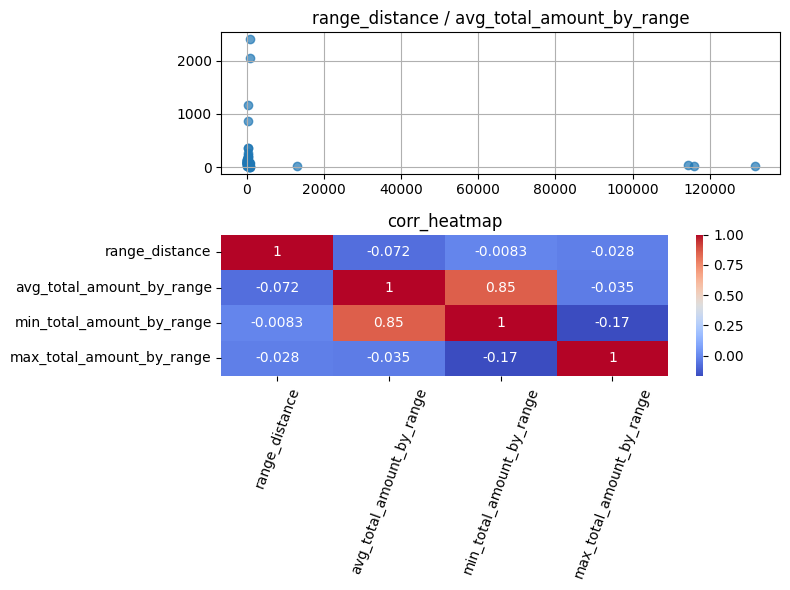

In [9]:
plt.figure(figsize = (8,6))

axes1 = plt.subplot(2,1,1)
axes1.scatter(df1['range_distance'], df1['avg_total_amount_by_range'], alpha = 0.7)
axes1.grid(True)
plt.title('range_distance / avg_total_amount_by_range')

axes2 = plt.subplot(2,1,2)
sns.heatmap(df1.corr(), annot =True, cmap = 'coolwarm')
plt.xticks(rotation = 70)
plt.title('corr_heatmap')

plt.tight_layout()
plt.show()

#### 2-1-5) 결론

<span style="
display : block;
background-color:#fff5b1;
color : red;
font-size : 20px;
font-weight : bold;
text-align : center;">[결론]</span>

- 이동 거리가 증가하면, 평균 운임이 음의 상관관계를 가져, 살짝 줄어드는 모습을 볼 수 있다
- 또한 이동 거리와 평균 운임의 p-value가 0.05 미만임에, 귀무가설(두 변수간 상관 관계가 없다)은 기각된다.
- 즉, 이동 거리와 평균 운임은 약한 음의 상관 관계를 가진다.- 

### 2-2. 피크 시간대 요금 분석

#### 2-2-1) 기초 통계 데이터 확인

In [120]:
ss.sql('''

    SELECT
        HOUR(tpep_pickup_datetime) as time_hour
        , COUNT(*) as cnt_HOUR
        , ROUND(AVG(total_amount), 2) as AVG_total_amount_by_HOUR
    
    FROM table1
    
    GROUP BY time_hour

    ORDER BY time_hour

''').show()

+---------+--------+------------------------+
|time_hour|cnt_HOUR|AVG_total_amount_by_HOUR|
+---------+--------+------------------------+
|        0|  273553|                   21.43|
|        1|  160424|                   20.84|
|        2|   97218|                   20.36|
|        3|   57806|                   21.07|
|        4|   45410|                   25.54|
|        5|   82073|                   26.55|
|        6|  241020|                   21.33|
|        7|  438938|                   18.84|
|        8|  641530|                   17.79|
|        9|  712912|                   17.59|
|       10|  794621|                   17.54|
|       11|  877952|                   17.47|
|       12|  970018|                   17.96|
|       13| 1001522|                   18.15|
|       14| 1084111|                   18.18|
|       15| 1091871|                   18.63|
|       16| 1043498|                   19.71|
|       17| 1085226|                   19.29|
|       18| 1087217|              

In [141]:
ss.sql('''

    SELECT
        HOUR(tpep_pickup_datetime) as time_hour
        , COUNT(*) as cnt_HOUR
    
    FROM table1
    
    GROUP BY time_hour

    ORDER BY cnt_HOUR DESC

    LIMIT 10;

''').show()

+---------+--------+
|time_hour|cnt_HOUR|
+---------+--------+
|       15| 1091871|
|       18| 1087217|
|       17| 1085226|
|       14| 1084111|
|       16| 1043498|
|       13| 1001522|
|       12|  970018|
|       19|  915477|
|       11|  877952|
|       10|  794621|
+---------+--------+



#### 2-2-2) Pandas 데이터프레임으로 만들기

In [15]:
df2 = ss.sql('''

    SELECT
        HOUR(tpep_pickup_datetime) as time_hour
        , COUNT(*) as cnt_HOUR
        , ROUND(AVG(total_amount), 2) as AVG_total_amount_by_HOUR
    
    FROM table1
    
    GROUP BY time_hour

    ORDER BY time_hour

''').toPandas()

#### 2-2-3) 상관계수 파악

In [123]:
df2.corr()

,time_hour,cnt_HOUR,AVG_total_amount_by_HOUR
time_hour,1.000000,0.644409,-0.412225
cnt_HOUR,0.644409,1.000000,-0.734082
AVG_total_amount_by_HOUR,-0.412225,-0.734082,1.000000


#### 2-2-4) 시각화

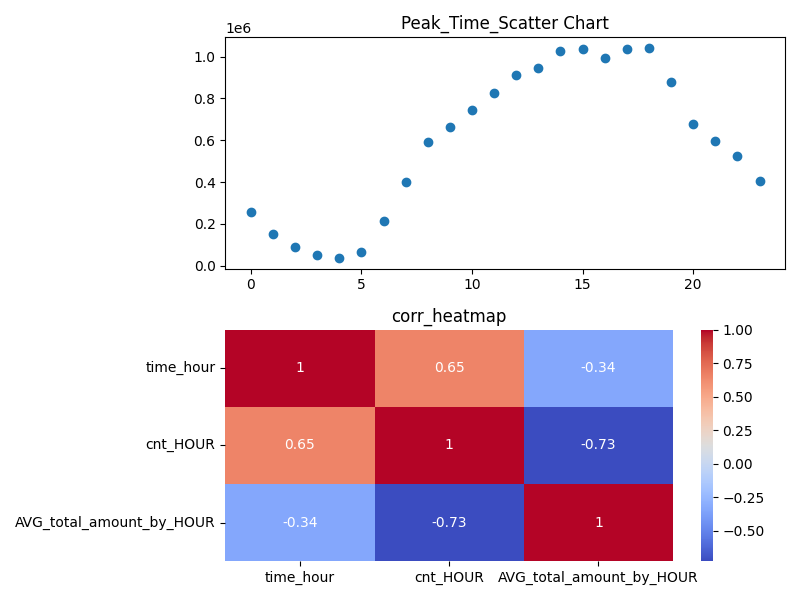

In [16]:
plt.figure(figsize=(8,6))

axes1 = plt.subplot(2,1,1)
axes1.scatter(df2['time_hour'], df2['cnt_HOUR'])
plt.title('Peak_Time_Scatter Chart')

axes2 = plt.subplot(2,1,2)
sns.heatmap(df2.corr(), annot = True, cmap = 'coolwarm')
plt.title('corr_heatmap')

plt.tight_layout()

plt.show()

In [151]:
statistic, pvalue = pearsonr(df2['cnt_HOUR'], df2['AVG_total_amount_by_HOUR'])
print(f'{pvalue:.20f}')

0.00004442707559947090


#### 2-2-5) 결론

<span style="
display : block;
background-color:#fff5b1;
color : red;
font-size : 20px;
font-weight : bold;
text-align : center;">[결론]</span>

- 피크 시간은 13시 ~ 18시에 많다.
- 시간 당 이용횟수가 증가할 수록, 시간 당 지불하는 총 금액의 평균은 낮아진다.
- 피크 시간에는 짧은 운임요금이 많으며 이는 짧은 거리일 수도 있다는 생각이 들게 된다.
- p-value 역시 시간 당 이용횟수와 시간 당 지불하는 총 금액의 평균이 매우 작은 값을 나타내고 있어, 두 변수간 상관관계가 없다는 귀무가설은 기각된다.
- 상관계수 역시, -0.73으로 음의 방향으로 강함을 확인할 수 있다.
- 즉, 시간 당 이용횟수는 시간 당 지불하는 총 금액의 평균과 음의 상관관계를 띄고 있다.

### 2-3. 지불 유형별 요금, 팁 분석

#### 2-3-1) 기초 통계 데이터 확인

In [37]:
ss.sql('''
        SELECT
        
            payment_type
            , ROUND(AVG(tip_amount), 2) as avg_tip_amount_by_payment_type
            , ROUND(AVG(total_amount), 2) as avg_total_amount_by_payment_type
            
        FROM table1
        
        GROUP BY payment_type

        ORDER BY payment_type

    ''')\
.show(20)

+------------+------------------------------+--------------------------------+
|payment_type|avg_tip_amount_by_payment_type|avg_total_amount_by_payment_type|
+------------+------------------------------+--------------------------------+
|           1|                          2.88|                           18.89|
|           2|                           0.0|                           15.42|
|           3|                         -0.01|                           18.07|
|           4|                          0.01|                           -2.77|
|           5|                           0.0|                            17.8|
+------------+------------------------------+--------------------------------+



In [45]:
ss.sql('''
    SELECT
        payment_type
        , ROUND(AVG(tip_amount), 2) as avg_tip_amount_by_payment_type
        , ROUND(AVG(total_amount), 2) as avg_total_amount_by_payment_type
        , ROUND(MIN((tip_amount / total_amount) * 100), 2) as min_tip_ratio
        , ROUND(AVG((tip_amount / total_amount) * 100), 2) as avg_tip_ratio
        , ROUND(MAX((tip_amount / total_amount) * 100), 2) as max_tip_ratio
    FROM table1 as A
    GROUP BY payment_type
    ORDER BY payment_type
    
''').show()

+------------+------------------------------+--------------------------------+-------------+-------------+-------------+
|payment_type|avg_tip_amount_by_payment_type|avg_total_amount_by_payment_type|min_tip_ratio|avg_tip_ratio|max_tip_ratio|
+------------+------------------------------+--------------------------------+-------------+-------------+-------------+
|           1|                          2.88|                           18.89|          0.0|        15.29|        100.0|
|           2|                           0.0|                           15.42|      -131.58|          0.0|        63.24|
|           3|                         -0.01|                           18.07|      -230.77|         0.13|        94.07|
|           4|                          0.01|                           -2.77|     -5666.67|        -0.29|        97.57|
|           5|                           0.0|                            17.8|          0.0|          0.0|          0.0|
+------------+------------------

#### 2-3-2) Pandas 데이터프레임으로 만들기

In [12]:
df3 = ss.sql('''
    SELECT
        payment_type
        , ROUND(AVG(tip_amount), 2) as avg_tip_amount_by_payment_type
        --, ROUND(AVG(total_amount), 2) as avg_total_amount_by_payment_type
        --, ROUND(MIN((tip_amount / total_amount) * 100), 2) as min_tip_ratio
        , ROUND(AVG((tip_amount / total_amount) * 100), 2) as avg_tip_ratio
        --, ROUND(MAX((tip_amount / total_amount) * 100), 2) as max_tip_ratio
    FROM table1 as A
    GROUP BY payment_type
    ORDER BY payment_type
    
    
''').toPandas()

In [52]:
tmp_df = ss.sql('''
    SELECT
    
        payment_type
        , tip_amount
        , total_amount
        
    FROM table1    
    
''').toPandas()

#### 2-3-3) 이상치 확인 및 제거

In [53]:
IQR_df = tmp_df.groupby('payment_type')['tip_amount'].describe()['75%'] \
        - tmp_df.groupby('payment_type')['tip_amount'].describe()['25%']
IQR_df

payment_type
1    1.51
2    0.00
3    0.00
4    0.00
5    0.00
dtype: float64

In [54]:
outlier_min = tmp_df.groupby('payment_type')['tip_amount'].describe()['25%'] - (1.5 * IQR_df)
outlier_min = outlier_min.loc[1]

outlier_max = tmp_df.groupby('payment_type')['tip_amount'].describe()['75%'] + (1.5 * IQR_df)
outlier_max = outlier_max.loc[1]

ss.sql(f'SET outlier_min = {outlier_min}')
ss.sql(f'SET outlier_max = {outlier_max}')


tmp_df= ss.sql('''
                SELECT
                
                    payment_type
                    , tip_amount
                    , total_amount
                    
                FROM table1
                WHERE payment_type = 1
                    AND tip_amount BETWEEN ${outlier_min} AND ${outlier_max}
                '''
              ).toPandas()

#### 2-3-4) 상관계수 파악

In [38]:
df3.corr()

,payment_type,avg_tip_amount_by_payment_type,avg_tip_ratio
payment_type,1.000000,-0.705869,-0.711771
avg_tip_amount_by_payment_type,-0.705869,1.000000,0.999615
avg_tip_ratio,-0.711771,0.999615,1.000000


In [67]:
((tmp_df['tip_amount'] / tmp_df['total_amount']) * 100).describe()

count    9.901148e+06
mean     1.496239e+01
std      5.394364e+00
min      0.000000e+00
25%      1.304348e+01
50%      1.666667e+01
75%      1.666667e+01
max      1.000000e+02
dtype: float64

#### 2-3-5) 시각화

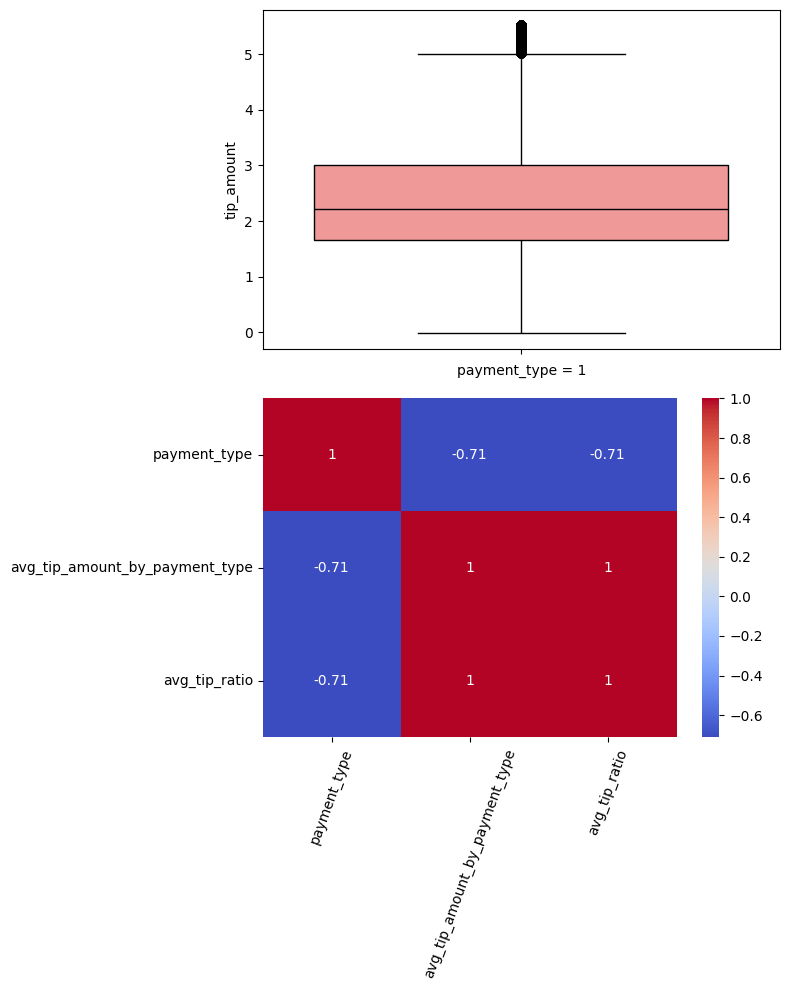

In [61]:
plt.figure(figsize = (8,10))

axes1 = plt.subplot(2,1,1)
sns.boxplot(data = tmp_df
           , y= 'tip_amount'
           , color = '#FF8A8A'
           , linecolor = '#000000'
           )
plt.xlabel('payment_type = 1')

axes2 = plt.subplot(2,1,2)
sns.heatmap(df3.corr(), annot = True, cmap = 'coolwarm')
plt.xticks(rotation = 70)


plt.tight_layout()
plt.show()

#### 2-3-6 결론

<span style="
display : block;
background-color:#fff5b1;
color : red;
font-size : 20px;
font-weight : bold;
text-align : center;">[결론]</span>

- 지불방법의 순서가 올라갈 수록 음의 상관관계를 보여주고 있다.
- Tip 지불 금액이 음수인 경우와 가히 큰 수에 대해 눈여겨 볼 필요가 있다.


### 4. 승차 지역 / 하차 지역별 평균거리, 요금

#### 2-4-1) 기초 통계 데이터 확인

In [13]:
ss.sql('''
    SELECT
        A.PULocationID
        , MAX(B.Zone) as PU_Zone
        , A.DOLocationID
        , MAX(C.Zone) as DO_Zone
        , ROUND(AVG(A.trip_distance), 2) as AVG_trip_distance
        , ROUND(AVG(A.total_amount), 2) as AVG_total_amount
        , COUNT(*) as cnt -- 건수 체크
    FROM table1 as A

    INNER JOIN table2 as B
    ON A.PULocationID = B.LocationID

    INNER JOIN table2 as C
    on A.DOLocationID = C.LocationID

    GROUP BY A.PULocationID, A.DOLocationID
''').show()

+------------+--------------------+------------+--------------------+-----------------+----------------+---+
|PULocationID|             PU_Zone|DOLocationID|             DO_Zone|AVG_trip_distance|AVG_total_amount|cnt|
+------------+--------------------+------------+--------------------+-----------------+----------------+---+
|           3|Allerton/Pelham G...|          57|              Corona|              4.8|           39.81|  2|
|           3|Allerton/Pelham G...|          89|Flatbush/Ditmas Park|            23.01|           74.73|  2|
|           4|       Alphabet City|         185|      Pelham Parkway|            10.91|           42.06| 11|
|           7|             Astoria|          55|        Coney Island|            14.82|           59.38| 23|
|           7|             Astoria|         132|         JFK Airport|            14.19|           49.42| 77|
|          10|        Baisley Park|          85|             Erasmus|            11.19|           49.95| 29|
|          10|     

#### 2-4-2) Pandas 데이터프레임으로 만들기

In [83]:
df4 = ss.sql('''
    SELECT
        A.PULocationID
        , MAX(B.Zone) as PU_Zone
        , A.DOLocationID
        , MAX(B.Zone) as DO_Zone
        , ROUND(AVG(A.trip_distance), 2) as AVG_trip_distance
        , ROUND(AVG(A.total_amount), 2) as AVG_total_amount
        , COUNT(*) as cnt -- 건수 체크
    FROM table1 as A

    INNER JOIN table2 as B
    ON A.PULocationID = B.LocationID

    GROUP BY A.PULocationID, A.DOLocationID
''').toPandas()

df4

,PULocationID,PU_Zone,DOLocationID,DO_Zone,AVG_trip_distance,AVG_total_amount,cnt
0,3,Allerton/Pelham Gardens,57,Allerton/Pelham Gardens,0.00,33.12,1
1,4,Alphabet City,185,Alphabet City,4.43,37.60,3
2,7,Astoria,55,Astoria,0.00,49.14,7
3,7,Astoria,132,Astoria,14.48,47.78,47
4,10,Baisley Park,85,Baisley Park,0.00,32.33,3
...,...,...,...,...,...,...,...
36166,263,Yorkville West,164,Yorkville West,3.30,20.20,3307
36167,263,Yorkville West,205,Yorkville West,16.92,62.67,6
36168,263,Yorkville West,236,Yorkville West,0.71,9.97,34821
36169,264,NV,191,NV,11.14,39.56,31


#### 2-4-3) 이상치 확인 및 제거

In [98]:
ss.sql('''
    SELECT
    A.PULocationID
    , A.DOLocationID
    , A.trip_distance
    , A.total_amount
    FROM table1 as A

    INNER JOIN table2 as B
    ON A.PULocationID = B.LocationID

    where A.total_amount > 0
        and A.trip_distance != 0

    -- 비용이 0 초과인데, 이동 거리가 0인 데이터 추출
        
''').count()

ss.sql('''
    SELECT
    A.PULocationID
    , A.DOLocationID
    , A.trip_distance
    , A.total_amount
    FROM table1 as A

    INNER JOIN table2 as B
    ON A.PULocationID = B.LocationID

    where A.total_amount > 0
        and A.trip_distance != 0

    -- 비용이 0 초과인데, 이동 거리가 0인 데이터 추출
        
''').show()


+------------+------------+-------------+------------+
|PULocationID|DOLocationID|trip_distance|total_amount|
+------------+------------+-------------+------------+
|         142|          43|          2.1|        11.8|
|         238|         151|          0.2|         4.3|
|         132|         165|         14.7|       51.95|
|         138|         132|         10.6|       36.35|
|          68|          33|         4.94|       24.36|
|         224|          68|          1.6|       14.15|
|          95|         157|          4.1|        17.3|
|          90|          40|          5.7|        21.8|
|          97|         129|          9.1|        28.8|
|         263|         142|          2.7|       18.95|
|         164|         255|         6.11|        24.3|
|         255|          80|         1.21|       10.79|
|         138|         166|          7.4|       33.92|
|         142|          50|          1.7|       14.16|
|          50|         142|         0.81|         8.3|
|         

In [99]:
# 정확한 이동 거리를 알 수 없으니 DROP으로 결정
df4 = ss.sql('''
    SELECT
        A.PULocationID
        , MAX(B.Zone) as PU_Zone
        , A.DOLocationID
        , MAX(B.Zone) as DO_Zone
        , ROUND(AVG(A.trip_distance), 2) as AVG_trip_distance
        , ROUND(AVG(A.total_amount), 2) as AVG_total_amount
        , COUNT(*) as cnt -- 건수 체크
    FROM table1 as A

    INNER JOIN table2 as B
    ON A.PULocationID = B.LocationID

    WHERE total_amount > 0
        and trip_distance != 0

    GROUP BY A.PULocationID, A.DOLocationID
''').toPandas()

df4

,PULocationID,PU_Zone,DOLocationID,DO_Zone,AVG_trip_distance,AVG_total_amount,cnt
0,4,Alphabet City,185,Alphabet City,13.30,42.80,1
1,7,Astoria,132,Astoria,14.48,47.78,47
2,10,Baisley Park,264,Baisley Park,5.85,48.08,8
3,11,Bath Beach,155,Bath Beach,9.72,32.80,1
4,12,Battery Park,115,Battery Park,12.04,50.04,2
...,...,...,...,...,...,...,...
30066,263,Yorkville West,164,Yorkville West,3.31,20.26,3297
30067,263,Yorkville West,205,Yorkville West,16.92,62.67,6
30068,263,Yorkville West,236,Yorkville West,0.71,10.09,34504
30069,264,NV,191,NV,11.14,39.56,31


#### 2-4-4) 상관계수 파악

In [100]:
df4[['AVG_trip_distance', 'AVG_total_amount', 'cnt']].corr()

,AVG_trip_distance,AVG_total_amount,cnt
AVG_trip_distance,1.000000,-0.000397,-0.003173
AVG_total_amount,-0.000397,1.000000,-0.172869
cnt,-0.003173,-0.172869,1.000000


### 5. 팁의 비율에 따른 거리, 여행 건수 서비스 관련 분석

In [15]:
ss.sql('''
        SELECT
        
            FLOOR(FLOOR(((tip_amount / total_amount) * 100))/10) * 10 as tip_ratio
            
        FROM table1
        where FLOOR(FLOOR(((tip_amount / total_amount) * 100))/10) * 10 < 0

''').show()

+---------+
|tip_ratio|
+---------+
|      -30|
|      -40|
|      -30|
|      -30|
|      -30|
|      -20|
|      -30|
|      -30|
|      -30|
|      -20|
|      -40|
|      -30|
|      -30|
|      -30|
|      -30|
|      -30|
|      -20|
|      -30|
|      -40|
|      -30|
+---------+
only showing top 20 rows



In [ ]:
ss.sql('''
        SELECT
        
            FLOOR(FLOOR(((tip_amount / total_amount) * 100))/10) * 10 as tip_ratio
            , ROUND(AVG(trip_distance), 2) as AVG_trip_distance
            , ROUND(AVG(tip_amount), 2) as AVG_tip_amount
            , ROUND(AVG(total_amount), 2) as AVG_total_amount
            
        FROM table1

        GROUP BY tip_ratio
        
        ORDER BY tip_ratio
''').show()

### 선형 모델로 택시비도 예측 모델 만들기

In [30]:
ss.stop()

## 99. 부록

### 컬럼 설명

| **Field Name**           | **Description**                                                                                                                                     |
|---------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------|
| **VendorID**             | A code indicating the TPEP provider that provided the record.                                                                                      |
|                           | - Creative Mobile Technologies                                                                                                                    |
|                           | - VeriFone Inc.                                                                                                                                   |
| **tpep_pickup_datetime**  | The date and time when the meter was engaged.                                                                                                      |
| **tpep_dropoff_datetime** | The date and time when the meter was disengaged.                                                                                                   |
| **Passenger_count**       | The number of passengers in the vehicle. This is a driver-entered value.                                                                           |
| **Trip_distance**         | The elapsed trip distance in miles reported by the taximeter.                                                                                     |
| **Pickup_longitude**      | Longitude where the meter was engaged.                                                                                                            |
| **Pickup_latitude**       | Latitude where the meter was engaged.                                                                                                             |
| **RateCodeID**            | The final rate code in effect at the end of the trip.                                                                                             |
|                           | - Standard rate                                                                                                                                   |
|                           | - JFK                                                                                                                                             |
|                           | - Newark                                                                                                                                          |
|                           | - Nassau or Westchester                                                                                                                           |
|                           | - Negotiated fare                                                                                                                                |
|                           | - Group ride                                                                                                                                      |
| **Store_and_fwd_flag**    | This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server. |
|                           | - `Y`: store and forward trip                                                                                                                     |
|                           | - `N`: not a store and forward trip                                                                                                               |
| **Dropoff_longitude**     | Longitude where the meter was disengaged.                                                                                                         |
| **Dropoff_latitude**      | Latitude where the meter was disengaged.                                                                                                          |
| **Payment_type**          | A numeric code signifying how the passenger paid for the trip.                                                                                    |
|                           | 1. Credit card                                                                                                                                    |
|                           | 2. Cash                                                                                                                                           |
|                           | 3. No charge                                                                                                                                      |
|                           | 4. Dispute                                                                                                                                         |
|                           | 5. Unknown                                                                                                                                        |
|                           | 6. Voided trip                                                                                                                                     |
| **Fare_amount**           | The time-and-distance fare calculated by the meter.                                                                                              |
| **Extra**                 | Miscellaneous extras and surcharges. Currently, this only includes the $0.50 and $1 rush hour and overnight charges.                              |
| **MTA_tax**               | $0.50 MTA tax that is automatically triggered based on the metered rate in use.                                                                   |
| **Improvement_surcharge** | $0.30 improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015.                                |
| **Tip_amount**            | Tip amount – This field is automatically populated for credit card tips. Cash tips are not included.                                              |
| **Tolls_amount**          | Total amount of all tolls paid in trip.                                                                                                           |
| **Total_amount**          | The total amount charged to passengers. Does not include cash tips.                                                                               |

